# 🚗 Project Summary: Predicting Daily Car Accidents

**Our project is to build a linear regression model to predict how many car accidents happen on a given day based on date-related and weather-related features.**

 

<a id="p1"></a>
# 1.  Importing Packages
We use the same modules as we would use for any problem working with data. We have numpy and pandas to work with numbers and data, and we have seaborn and matplotlib to visualize data. We would also like to filter out unnecessary warnings.

In [1]:
import numpy as np 
import pandas as pd 
import holidays
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

<a id="p2"></a>
#  Loading and Inspecting Data
With various Pandas functions, we load our training and test data set as well as inspect it to get an idea of the data we're working with. Wow! That is a large data set; just take a look at its shape. We're going to have to understand our data before modelling. 

In [2]:
train_df = pd.read_csv('/kaggle/input/us-accidents/US_Accidents_March23.csv')


 

In [3]:
train_df.shape

(7728394, 46)

In [4]:
train_df.describe()



,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


<a id="p2"></a>
#  Cleaning Data

In [5]:
train_df = train_df.drop(['Start_Lat','Start_Lng','End_Lat','End_Lng','Description','Street',
                          'City','County','Zipcode','Country','Timezone','Airport_Code',
                          'Weather_Timestamp','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], axis=1)



In [6]:
print(train_df['Source'].value_counts().sort_index())
my_df = train_df[train_df['Source'] == train_df['Source'].value_counts().idxmax()].reset_index(drop=True)
my_df.shape

Source
Source1    4325632
Source2    3305373
Source3      97389
Name: count, dtype: int64


(4325632, 30)

In [7]:
my_df['Temperature(C)'] = (my_df['Temperature(F)'] - 32) * 5.0 / 9.0
bins = [-50, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['< -20°C', '-20–-10°C', '-10–0°C', '0–10°C', '10–20°C', '20–30°C', '30–40°C', '40–50°C', '50+°C']
my_df['Temperature_Range'] = pd.cut(my_df['Temperature(C)'], bins=bins, labels=labels, right=False)
print (my_df['Temperature_Range'].value_counts().sort_index())

Temperature_Range
< -20°C         7958
-20–-10°C      45127
-10–0°C       274551
0–10°C        788351
10–20°C      1327873
20–30°C      1413811
30–40°C       355414
40–50°C         6370
50+°C             31
Name: count, dtype: int64


In [8]:
temp_ranges = {
    "< -20°C": -20,
    "-20–-10°C": -15,
    "-10–0°C": -5,
    "0–10°C": 5,
    "10–20°C": 15,
    "20–30°C": 25,
    "30–40°C": 35,
    "40–50°C": 45,
    "50+°C": 50
}

my_df['Temperature_Midpoint'] = my_df['Temperature_Range'].map(temp_ranges)
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Temperature_Midpoint']])
#encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Temperature_Midpoint']))
encoded_df = pd.DataFrame(
    encoded_array, 
    columns=[f"Temperature_Value_{cat}" for cat in encoder.categories_[0]]
).astype(int)
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)
my_df = my_df_encoded
print(my_df.head(20))











           ID   Source  Severity           Start_Time             End_Time  \
0   A-3412645  Source1         3  2016-02-08 00:37:08  2016-02-08 06:37:08   
1   A-3412646  Source1         2  2016-02-08 05:56:20  2016-02-08 11:56:20   
2   A-3412647  Source1         2  2016-02-08 06:15:39  2016-02-08 12:15:39   
3   A-3412648  Source1         2  2016-02-08 06:15:39  2016-02-08 12:15:39   
4   A-3412649  Source1         2  2016-02-08 06:51:45  2016-02-08 12:51:45   
5   A-3412650  Source1         3  2016-02-08 07:53:43  2016-02-08 13:53:43   
6   A-3412651  Source1         2  2016-02-08 08:16:57  2016-02-08 14:16:57   
7   A-3412652  Source1         2  2016-02-08 08:16:57  2016-02-08 14:16:57   
8   A-3412653  Source1         2  2016-02-08 08:15:41  2016-02-08 14:15:41   
9   A-3412654  Source1         2  2016-02-08 11:51:46  2016-02-08 17:51:46   
10  A-3412655  Source1         2  2016-02-08 14:19:57  2016-02-08 20:19:57   
11  A-3412656  Source1         2  2016-02-08 15:16:43  2016-02-0

In [9]:
my_df['Wind_Chill(C)'] = (my_df['Wind_Chill(F)'] - 32) * 5.0 / 9.0
my_df = my_df.drop(['Wind_Chill(F)'], axis=1)
bins = [-50, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['< -20°C', '-20–-10°C', '-10–0°C', '0–10°C', '10–20°C', '20–30°C', '30–40°C', '40–50°C', '50+°C']
my_df['Wind_Chill_Range'] = pd.cut(my_df['Wind_Chill(C)'], bins=bins, labels=labels, right=False)
print (my_df['Wind_Chill_Range'].value_counts().sort_index())

Wind_Chill_Range
< -20°C        32229
-20–-10°C      91494
-10–0°C       350576
0–10°C        592978
10–20°C      1161769
20–30°C      1241695
30–40°C       311920
40–50°C         5354
50+°C             26
Name: count, dtype: int64


In [10]:
# Create bins and labels for Humidity range
humidity_bins = [0, 20, 40, 60, 80, 100]
humidity_labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
my_df['Humidity_Range'] = pd.cut(my_df['Humidity(%)'], bins=humidity_bins, labels=humidity_labels, include_lowest=True)

# Count the number of records in each humidity range
#humidity_range_counts = my_df['Humidity_Range'].value_counts().sort_index()
my_df['Humidity_Range'] = my_df['Humidity_Range']
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Humidity_Range']])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=[f"Humidity_Value_{cat}" for cat in encoder.categories_[0]]
).astype(int)
# Concatenate the original dataframe with the one-hot encoded columns
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)
my_df = my_df_encoded
print("\nEncoded DataFrame:")
print(my_df.head(20))







Encoded DataFrame:
           ID   Source  Severity           Start_Time             End_Time  \
0   A-3412645  Source1         3  2016-02-08 00:37:08  2016-02-08 06:37:08   
1   A-3412646  Source1         2  2016-02-08 05:56:20  2016-02-08 11:56:20   
2   A-3412647  Source1         2  2016-02-08 06:15:39  2016-02-08 12:15:39   
3   A-3412648  Source1         2  2016-02-08 06:15:39  2016-02-08 12:15:39   
4   A-3412649  Source1         2  2016-02-08 06:51:45  2016-02-08 12:51:45   
5   A-3412650  Source1         3  2016-02-08 07:53:43  2016-02-08 13:53:43   
6   A-3412651  Source1         2  2016-02-08 08:16:57  2016-02-08 14:16:57   
7   A-3412652  Source1         2  2016-02-08 08:16:57  2016-02-08 14:16:57   
8   A-3412653  Source1         2  2016-02-08 08:15:41  2016-02-08 14:15:41   
9   A-3412654  Source1         2  2016-02-08 11:51:46  2016-02-08 17:51:46   
10  A-3412655  Source1         2  2016-02-08 14:19:57  2016-02-08 20:19:57   
11  A-3412656  Source1         2  2016-02-08

In [11]:
# Define bins and labels for Visibility ranges
visibility_bins = [0, 1, 3, 5, 10, 20, float('inf')]
visibility_labels = ['0-1 mi', '1-3 mi', '3-5 mi', '5-10 mi', '10-20 mi', '20+ mi']

# Bin the Visibility(mi) values
my_df['Visibility_Range'] = pd.cut(my_df['Visibility(mi)'], bins=visibility_bins, labels=visibility_labels, include_lowest=True)

# Count the number of records in each range
visibility_counts = my_df['Visibility_Range'].value_counts().sort_index()

# Display the result
print("Visibility Range Counts:")
print(visibility_counts)

visibility_bins = [0, 1, 3, 5, 10, 20, float('inf')]
visibility_labels = ['0-1 mi', '1-3 mi', '3-5 mi', '5-10 mi', '10-20 mi', '20+ mi']
my_df['Visibility_Range'] = pd.cut(my_df['Visibility(mi)'], bins=visibility_bins, labels=visibility_labels, right=False)

encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Visibility_Range']])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=[f"Visibility_Value_{cat}" for cat in encoder.categories_[0]]
).astype(int)
# Concatenate the original dataframe with the one-hot encoded columns
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)
my_df = my_df_encoded
print("\nEncoded DataFrame:")
print(my_df)



Visibility Range Counts:
Visibility_Range
0-1 mi       137770
1-3 mi       149697
3-5 mi       142448
5-10 mi     3768744
10-20 mi      11011
20+ mi         4458
Name: count, dtype: int64

Encoded DataFrame:
                ID   Source  Severity           Start_Time  \
0        A-3412645  Source1         3  2016-02-08 00:37:08   
1        A-3412646  Source1         2  2016-02-08 05:56:20   
2        A-3412647  Source1         2  2016-02-08 06:15:39   
3        A-3412648  Source1         2  2016-02-08 06:15:39   
4        A-3412649  Source1         2  2016-02-08 06:51:45   
...            ...      ...       ...                  ...   
4325627  A-7777757  Source1         2  2019-08-23 18:03:25   
4325628  A-7777758  Source1         2  2019-08-23 19:11:30   
4325629  A-7777759  Source1         2  2019-08-23 19:00:21   
4325630  A-7777760  Source1         2  2019-08-23 19:00:21   
4325631  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Distance(mi) Stat

In [12]:
def classify_precip(p):
    if pd.isna(p) or p == 0:
        return 'None'
    elif p < 0.10:
        return 'Light'
    elif p <= 0.30:
        return 'Moderate'
    else:
        return 'Heavy'

my_df['Precipitation_Level'] = my_df['Precipitation(in)'].apply(classify_precip)
my_df['Precipitation_Level'].value_counts().sort_index()

encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Precipitation_Level']])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=[f"Precipitation_Values_{cat}" for cat in encoder.categories_[0]]
).astype(int)
# Concatenate the original dataframe with the one-hot encoded columns
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)
my_df = my_df_encoded
print("\nEncoded DataFrame:")
print(my_df.head(20))


Encoded DataFrame:
           ID   Source  Severity           Start_Time             End_Time  \
0   A-3412645  Source1         3  2016-02-08 00:37:08  2016-02-08 06:37:08   
1   A-3412646  Source1         2  2016-02-08 05:56:20  2016-02-08 11:56:20   
2   A-3412647  Source1         2  2016-02-08 06:15:39  2016-02-08 12:15:39   
3   A-3412648  Source1         2  2016-02-08 06:15:39  2016-02-08 12:15:39   
4   A-3412649  Source1         2  2016-02-08 06:51:45  2016-02-08 12:51:45   
5   A-3412650  Source1         3  2016-02-08 07:53:43  2016-02-08 13:53:43   
6   A-3412651  Source1         2  2016-02-08 08:16:57  2016-02-08 14:16:57   
7   A-3412652  Source1         2  2016-02-08 08:16:57  2016-02-08 14:16:57   
8   A-3412653  Source1         2  2016-02-08 08:15:41  2016-02-08 14:15:41   
9   A-3412654  Source1         2  2016-02-08 11:51:46  2016-02-08 17:51:46   
10  A-3412655  Source1         2  2016-02-08 14:19:57  2016-02-08 20:19:57   
11  A-3412656  Source1         2  2016-02-08

In [13]:
print(my_df['Weather_Condition'].unique())

my_df['Weather_Simplified'] = 'Other'

my_df.loc[my_df['Weather_Condition'].str.contains(r'Snow|Sleet|Hail|Ice', case=False, na=False), 'Weather_Simplified'] = 'Snow'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Rain|Precipitation|Drizzle', case=False, na=False), 'Weather_Simplified'] = 'Rain'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Thunder|T-Storm', case=False, na=False), 'Weather_Simplified'] = 'Thunder'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Cloud|Overcast', case=False, na=False), 'Weather_Simplified'] = 'Cloudy'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Fog|Haze|Mist', case=False, na=False), 'Weather_Simplified'] = 'Fog'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Dust|Sand', case=False, na=False), 'Weather_Simplified'] = 'Dust'
my_df.loc[my_df['Weather_Condition'].str.contains('Smoke', case=False, na=False), 'Weather_Simplified'] = 'Smoke'
my_df.loc[my_df['Weather_Condition'].str.contains('Fair', case=False, na=False), 'Weather_Simplified'] = 'Fair'
my_df.loc[my_df['Weather_Condition'].str.contains('Wintry', case=False, na=False), 'Weather_Simplified'] = 'Wintry'
my_df.loc[my_df['Weather_Condition'].str.contains('Squalls', case=False, na=False), 'Weather_Simplified'] = 'Squalls'
my_df = my_df.drop(['Weather_Condition'], axis=1)

print(my_df['Weather_Simplified'].value_counts().head(20))


encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Weather_Simplified']])
#encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Temperature_Midpoint']))
encoded_df = pd.DataFrame(
    encoded_array, 
    columns=[f"Weather_Value_{cat}" for cat in encoder.categories_[0]]
).astype(int)
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)
my_df = my_df_encoded
print(my_df.head(20))

['Light Rain' 'Overcast' 'Mostly Cloudy' 'Snow' 'Light Snow' 'Cloudy' nan
 'Scattered Clouds' 'Clear' 'Partly Cloudy' 'Light Freezing Drizzle'
 'Light Drizzle' 'Haze' 'Rain' 'Heavy Rain' 'Fair' 'Drizzle' 'Fog'
 'Thunderstorms and Rain' 'Patches of Fog' 'Light Thunderstorms and Rain'
 'Mist' 'Rain Showers' 'Light Rain Showers' 'Heavy Drizzle' 'Smoke'
 'Light Freezing Fog' 'Light Freezing Rain' 'Blowing Snow'
 'Heavy Thunderstorms and Rain' 'Heavy Snow' 'Snow Grains' 'Squalls'
 'Light Fog' 'Shallow Fog' 'Thunderstorm' 'Light Ice Pellets' 'Thunder'
 'Thunder in the Vicinity' 'Fair / Windy' 'Light Rain with Thunder'
 'Heavy Thunderstorms and Snow' 'Light Snow Showers' 'Cloudy / Windy'
 'Ice Pellets' 'N/A Precipitation' 'Light Thunderstorms and Snow'
 'T-Storm' 'Rain / Windy' 'Wintry Mix' 'Partly Cloudy / Windy'
 'Heavy T-Storm' 'Sand' 'Light Rain / Windy' 'Widespread Dust'
 'Mostly Cloudy / Windy' 'Blowing Dust / Windy' 'Blowing Dust'
 'Volcanic Ash' 'Freezing Rain / Windy' 'Small Hail' 'W

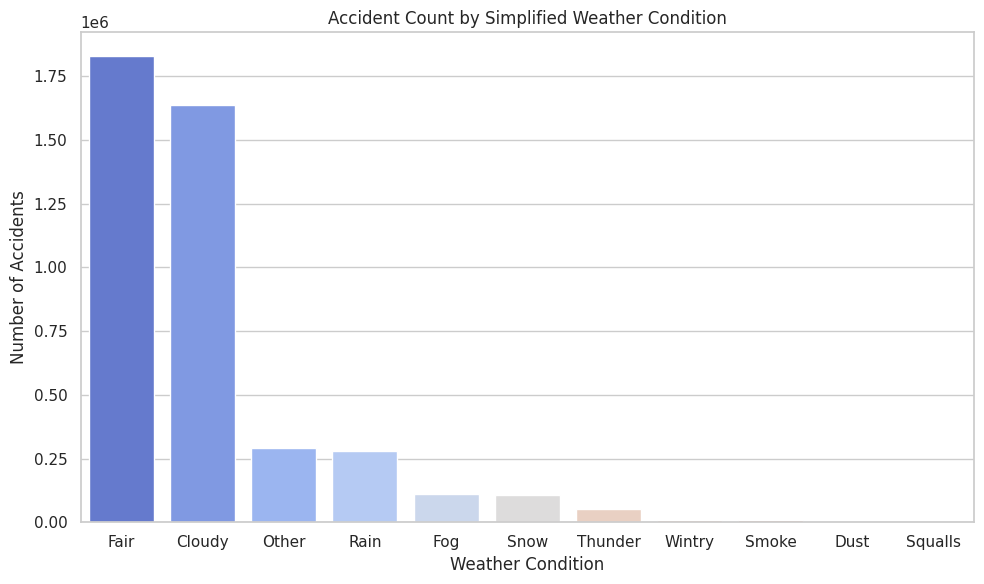

In [14]:
accidents_by_weather = my_df['Weather_Simplified'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_by_weather.index, y=accidents_by_weather.values, palette="coolwarm")
plt.title("Accident Count by Simplified Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

In [15]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'], errors='coerce')
print("Total rows : ", my_df.shape[0])
print("Valid rows : ", my_df[my_df['Start_Time'].notna()].shape[0])
my_df = my_df[my_df['Start_Time'].notna()]

Total rows :  4325632
Valid rows :  3582466


### <a id="p2"></a>
# 3. EDA

Accidents per day:

Group by date and count accidents.

Plot a time series to check trends (e.g., increasing/decreasing).


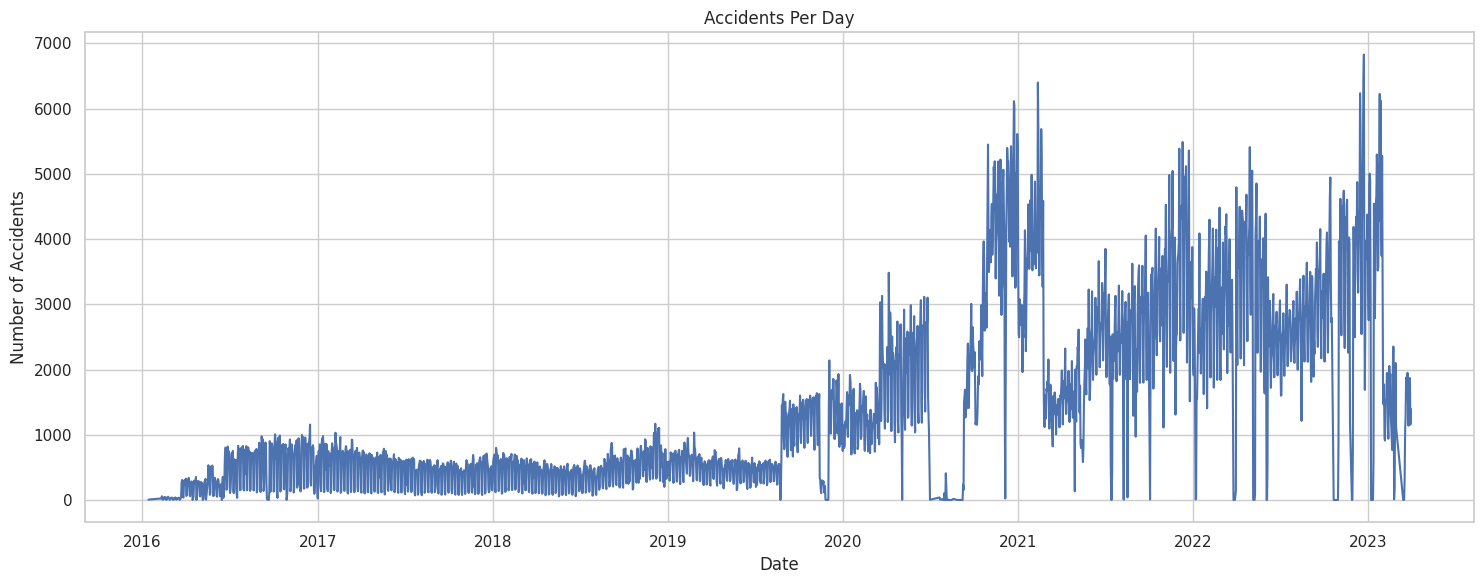

In [16]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])

# Extract just the date part (without time)
my_df['Date'] = my_df['Start_Time'].dt.date

# Group by date and count the number of accidents
accidents_per_day = my_df.groupby('Date').size().reset_index(name='accident_count')

# Convert 'Date' back to datetime for proper plotting
accidents_per_day['Date'] = pd.to_datetime(accidents_per_day['Date'])

# Plot the time series
plt.figure(figsize=(15, 6))
sns.lineplot(data=accidents_per_day, x='Date', y='accident_count')
plt.title("Accidents Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

Day of week effects:

Are weekends more dangerous than weekdays?

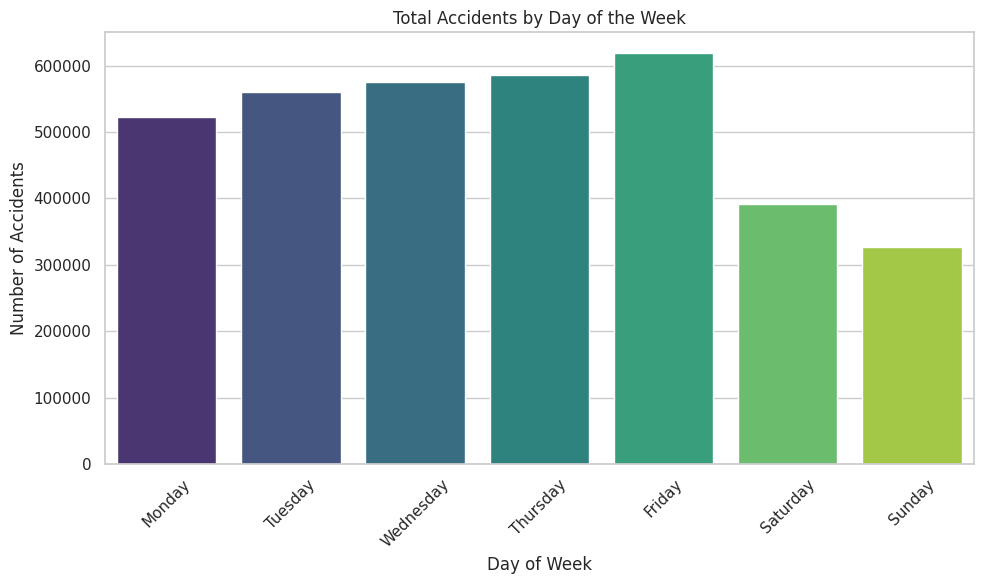

In [17]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])

# Extract day of the week (0=Monday, 6=Sunday)
my_df['DayOfWeek'] = my_df['Start_Time'].dt.dayofweek
my_df['DayName'] = my_df['Start_Time'].dt.day_name()

# Group by day name and count number of accidents
accidents_by_day = my_df['DayName'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_by_day.index, y=accidents_by_day.values, palette='viridis')
plt.title("Total Accidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What time are most accidents happening? (Rush hours?)

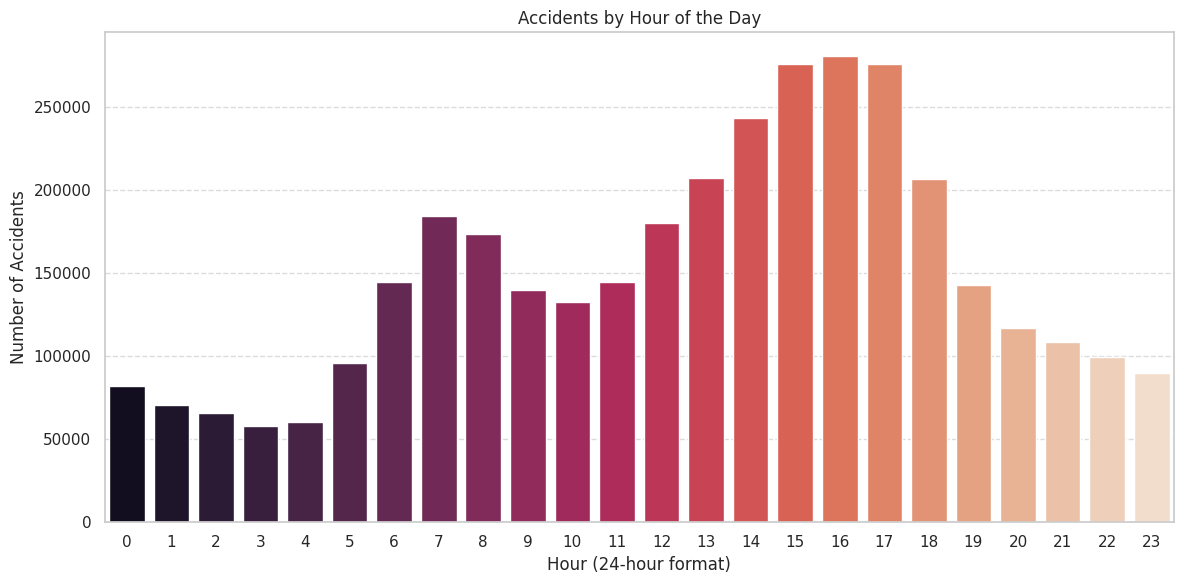

In [18]:

# Convert to datetime if not already
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])

# Extract the hour of the day (0 to 23)
my_df['Hour'] = my_df['Start_Time'].dt.hour

# Count accidents by hour
accidents_by_hour = my_df['Hour'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=accidents_by_hour.index, y=accidents_by_hour.values, palette='rocket')
plt.title("Accidents by Hour of the Day")
plt.xlabel("Hour (24-hour format)")
plt.ylabel("Number of Accidents")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


suggestion is to create  a new feature: rush_hour = (7–8 AM or 4–6 PM)

Do winter months see more accidents?

Correlation between each weather condition and accident count.

Accident rate by weather condition:

More accidents during rainy or snowy days?

Do more accidents happen near traffic signals?

Does this rate change by:

Time of day? (e.g., are intersections more dangerous during rush hours?)

Weather? (e.g., rain + traffic light = more accidents?)

Is there a correlation between traffic signals and accident severity or distance?

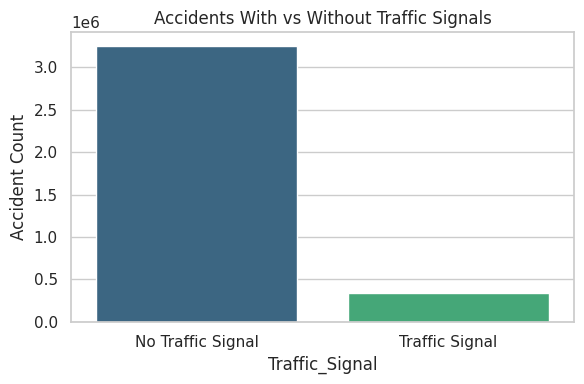

In [19]:
signal_counts = my_df['Traffic_Signal'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=signal_counts.index, y=signal_counts.values, palette='viridis')
plt.xticks([0,1], ['No Traffic Signal', 'Traffic Signal'])
plt.ylabel("Accident Count")
plt.title("Accidents With vs Without Traffic Signals")
plt.tight_layout()
plt.show()


Does this rate change by time of day?


Does this rate change by weather condition?


Are accidents more likely to occur near stations?

Is this rate higher in urban vs. rural areas?

Do high station rates correlate with shorter travel distances or less severity?

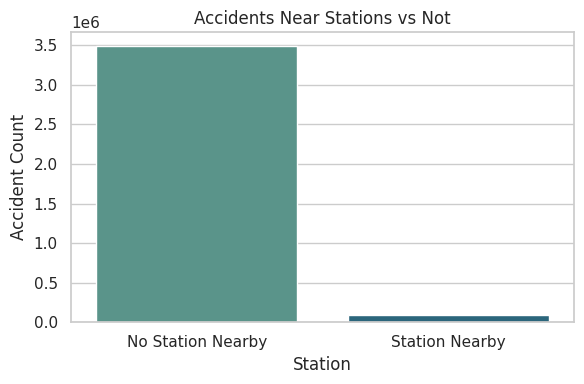

In [20]:
station_counts = my_df['Station'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=station_counts.index, y=station_counts.values, palette='crest')
plt.xticks([0,1], ['No Station Nearby', 'Station Nearby'])
plt.ylabel("Accident Count")
plt.title("Accidents Near Stations vs Not")
plt.tight_layout()
plt.show()


Correlation between traffic signal and severity / distance

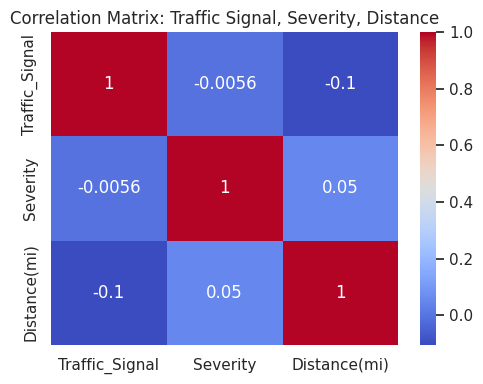

In [21]:
correlations = my_df[['Traffic_Signal', 'Severity', 'Distance(mi)']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Traffic Signal, Severity, Distance")
plt.tight_layout()
plt.show()

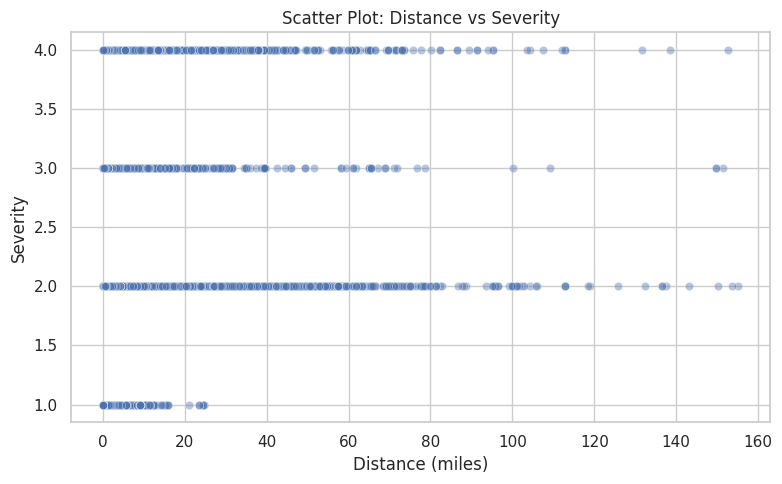

In [22]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=my_df, x='Distance(mi)', y='Severity', alpha=0.4)
plt.title("Scatter Plot: Distance vs Severity")
plt.xlabel("Distance (miles)")
plt.ylabel("Severity")
plt.tight_layout()
plt.show()

### 🔍 Quick Recap of Correlations

| **Feature**         | **Correlation with `accident_count`** | **Interpretation**                |
|---------------------|----------------------------------------|------------------------------------|
| Temperature (°C)     | `-0.023413`                                | Negligible correlation             |
| Humidity (%)         | `+0.026`                                | Weak positive correlation          |
| Wind Chill (°F)      | `0.177`                                | Negligible negative correlation    |


A correlation of –0.006 between Visibility and Accident Count indicates a negligible (almost zero) linear relationship

### <a id="p2"></a>

# 3. Extracting Start_Time and Sunrise_Sunset

We start by extracting some useful time-based features from the `Start_Time` column and a flag based on the `Sunrise_Sunset` column: 





In [23]:
my_df['Date'] = my_df['Start_Time'].dt.normalize()
my_df['Weekday'] = my_df['Start_Time'].dt.weekday
my_df['day_of_week'] = my_df['Start_Time'].dt.dayofweek
my_df['Weekday_Name'] = my_df['Start_Time'].dt.day_name()
my_df['Hour'] = my_df['Start_Time'].dt.hour
my_df['Month'] = my_df['Start_Time'].dt.month
my_df['Month_Name'] = my_df['Start_Time'].dt.month_name()
my_df['Is_Weekend'] = my_df['Weekday'].isin([5,6]).astype(int)
my_df['Is_Night'] = my_df['Sunrise_Sunset'].map({'Night': 1, 'Day': 0}).fillna(0).astype(int)



us_holidays = holidays.US()
my_df['Is_Holiday'] = my_df['Date'].apply(lambda x: 1 if x in us_holidays else 0).astype(int)


def get_hour_risk_level(hour):
    if hour in [13, 14, 15, 16, 17, 18]:
        return 'High'
    elif hour in [6, 7, 8, 9, 10, 11, 12, 19]:
        return 'Medium'
    else:
        return 'Low'

my_df['Hour_Risk_Level'] = my_df['Hour'].apply(get_hour_risk_level)

my_df[['Month', 'Is_Weekend', 'Date', 'Start_Time', 'day_of_week','Is_Night','Is_Holiday','Hour_Risk_Level']]
my_df.head(20)


,ID,Source,Severity,Start_Time,End_Time,Distance(mi),State,Temperature(F),Humidity(%),Pressure(in),...,Hour,Weekday,day_of_week,Weekday_Name,Month,Month_Name,Is_Weekend,Is_Night,Is_Holiday,Hour_Risk_Level
0,A-3412645,Source1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,3.230,OH,42.1,58.0,29.76,...,0,0,0,Monday,2,February,0,1,0,Low
1,A-3412646,Source1,2,2016-02-08 05:56:20,2016-02-08 11:56:20,0.747,OH,36.9,91.0,29.68,...,5,0,0,Monday,2,February,0,1,0,Low
2,A-3412647,Source1,2,2016-02-08 06:15:39,2016-02-08 12:15:39,0.055,OH,36.0,97.0,29.70,...,6,0,0,Monday,2,February,0,1,0,Medium
3,A-3412648,Source1,2,2016-02-08 06:15:39,2016-02-08 12:15:39,0.219,OH,36.0,97.0,29.70,...,6,0,0,Monday,2,February,0,1,0,Medium
4,A-3412649,Source1,2,2016-02-08 06:51:45,2016-02-08 12:51:45,0.123,OH,39.0,55.0,29.65,...,6,0,0,Monday,2,February,0,1,0,Medium
5,A-3412650,Source1,3,2016-02-08 07:53:43,2016-02-08 13:53:43,0.500,OH,37.0,93.0,29.69,...,7,0,0,Monday,2,February,0,0,0,Medium
6,A-3412651,Source1,2,2016-02-08 08:16:57,2016-02-08 14:16:57,1.427,OH,35.6,100.0,29.66,...,8,0,0,Monday,2,February,0,0,0,Medium
7,A-3412652,Source1,2,2016-02-08 08:16:57,2016-02-08 14:16:57,1.423,OH,35.6,100.0,29.66,...,8,0,0,Monday,2,February,0,0,0,Medium
8,A-3412653,Source1,2,2016-02-08 08:15:41,2016-02-08 14:15:41,0.227,OH,33.8,100.0,29.63,...,8,0,0,Monday,2,February,0,0,0,Medium
9,A-3412654,Source1,2,2016-02-08 11:51:46,2016-02-08 17:51:46,0.521,OH,33.1,92.0,29.63,...,11,0,0,Monday,2,February,0,0,0,Medium


In [24]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Define your risk level map
risk_level_map = {'Low': 0, 'Medium': 1, 'High': 2}

# Fill NaN values in 'Hour_Risk_Score' and map 'Hour_Risk_Level' to 'Hour_Risk_Score'
my_df['Hour_Risk_Score'] = my_df['Hour_Risk_Level'].map(risk_level_map).fillna(0).astype(int)

# Perform one-hot encoding on 'Hour_Risk_Score'
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Hour_Risk_Score']])

# Create DataFrame for encoded columns and ensure the result is of type int
encoded_df = pd.DataFrame(
    encoded_array,  # Already encoded as int
    columns=[f"HourRisk_Value_{cat}" for cat in encoder.categories_[0]]
)

# Concatenate encoded columns back to the original DataFrame (my_df)
my_df = pd.concat([my_df, encoded_df], axis=1)

# Step 1: Identify columns with '.0' suffix
columns_to_merge = [col for col in my_df.columns if '.0' in col]

# Step 2: Merge the '.0' columns with their corresponding integer columns
for col in columns_to_merge:
    base_col = col.replace('.0', '')  # Remove '.0' to get the base name
    if base_col in my_df.columns:
        # Perform bitwise OR to combine the columns (1 if either is 1)
        my_df[base_col] = my_df[base_col] | my_df[col]
        my_df.drop(col, axis=1, inplace=True)  # Drop the '.0' column after merging



# Print the final DataFrame
print(my_df)



                ID   Source  Severity          Start_Time  \
0        A-3412645  Source1       3.0 2016-02-08 00:37:08   
1        A-3412646  Source1       2.0 2016-02-08 05:56:20   
2        A-3412647  Source1       2.0 2016-02-08 06:15:39   
3        A-3412648  Source1       2.0 2016-02-08 06:15:39   
4        A-3412649  Source1       2.0 2016-02-08 06:51:45   
...            ...      ...       ...                 ...   
3431318        NaN      NaN       NaN                 NaT   
3431319        NaN      NaN       NaN                 NaT   
3431320        NaN      NaN       NaN                 NaT   
3431321        NaN      NaN       NaN                 NaT   
3431322        NaN      NaN       NaN                 NaT   

                    End_Time  Distance(mi) State  Temperature(F)  Humidity(%)  \
0        2016-02-08 06:37:08         3.230    OH            42.1         58.0   
1        2016-02-08 11:56:20         0.747    OH            36.9         91.0   
2        2016-02-08 12:1

    Hour  Hour_Risk_Score  Accident_Count
0    0.0              0.0           81908
1    1.0              0.0           70768
2    2.0              0.0           66021
3    3.0              0.0           57910
4    4.0              0.0           60426
5    5.0              0.0           96170
6    6.0              1.0          144665
7    7.0              1.0          184643
8    8.0              1.0          173664
9    9.0              1.0          139896
10  10.0              1.0          132448
11  11.0              1.0          144641
12  12.0              1.0          180498
13  13.0              2.0          207448
14  14.0              2.0          243312
15  15.0              2.0          276284
16  16.0              2.0          281031
17  17.0              2.0          276092
18  18.0              2.0          206909
19  19.0              1.0          143123
20  20.0              0.0          116880
21  21.0              0.0          108291
22  22.0              0.0         

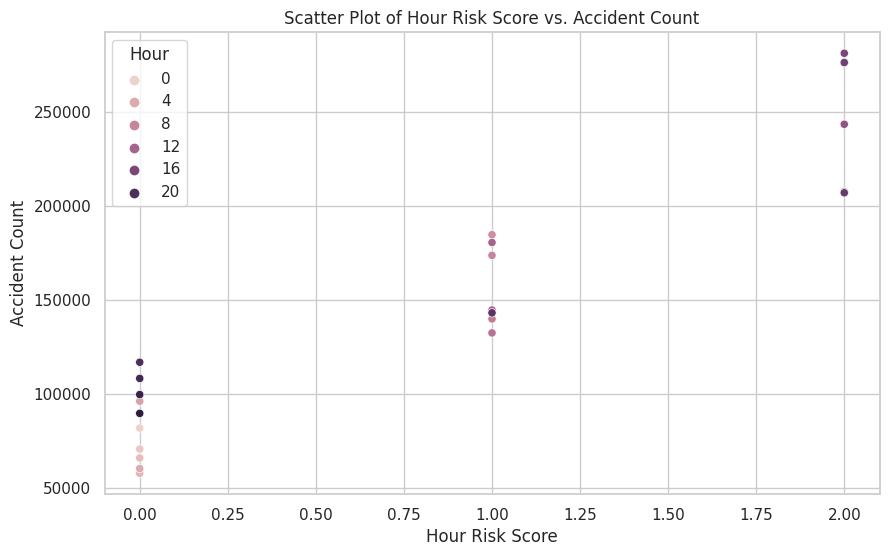

In [25]:
hourly_stats = my_df.groupby('Hour').agg({
    'Hour_Risk_Score': 'mean',  # Average risk score per hour
}).reset_index()

# If you need to count accidents, you can use .size() instead of 'Accident_Count'
hourly_stats['Accident_Count'] = my_df.groupby('Hour').size().values
print(hourly_stats)

# Assuming hourly_stats is now correctly defined
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hourly_stats['Hour_Risk_Score'], y=hourly_stats['Accident_Count'], hue=hourly_stats['Hour'])
plt.title('Scatter Plot of Hour Risk Score vs. Accident Count')
plt.xlabel('Hour Risk Score')
plt.ylabel('Accident Count')
plt.show()

I might expect more accidents during rush hours due to increased traffic volume and congestion. However, the correlation I found might not necessarily mean that rush hour leads to fewer accidents. There are several reasons why this might be happening:
 During rush hours, traffic is often slower, which might reduce the likelihood of certain types    of accidents (e.g., high-speed collisions).

 Traffic management and signaling are often optimized to prevent accidents during peak hours.
 During rush hour, drivers may drive more cautiously due to heavy traffic, lower speeds, and   higher awareness of the risk of accidents.

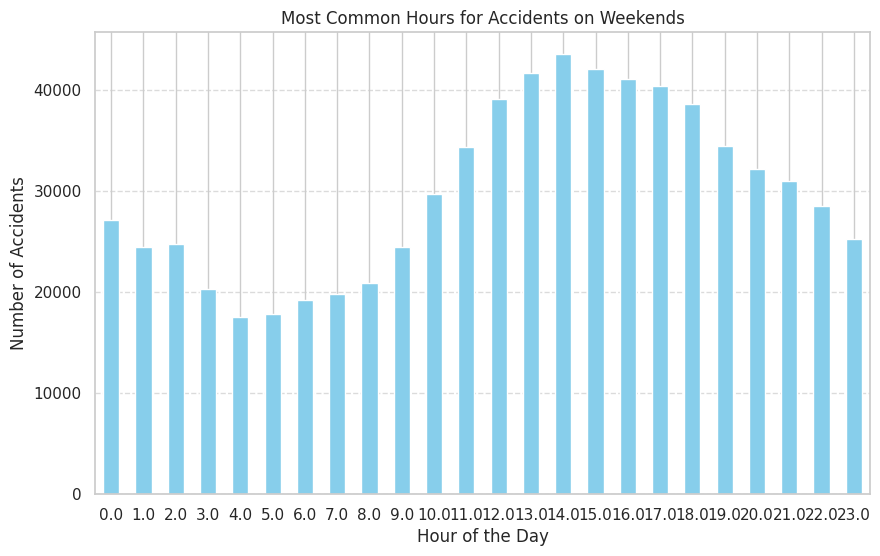

Hours with the most accidents:
Hour
14.0    43521
15.0    42094
13.0    41655
16.0    41092
17.0    40350
12.0    39120
18.0    38612
19.0    34466
11.0    34350
20.0    32177
21.0    30984
10.0    29747
dtype: int64


In [26]:


# Filter for weekends (Is_Weekend is True)
weekend_data = my_df[my_df['Is_Weekend'] == True]

# Group by Hour and count accidents
accidents_by_hour_weekend = weekend_data.groupby('Hour').size()

# Plot the results
plt.figure(figsize=(10, 6))
accidents_by_hour_weekend.plot(kind='bar', color='skyblue')
plt.title('Most Common Hours for Accidents on Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

peak_hours = accidents_by_hour_weekend.sort_values(ascending=False).head(12)  # Top 5 hours with the most accidents
print("Hours with the most accidents:")
print(peak_hours)

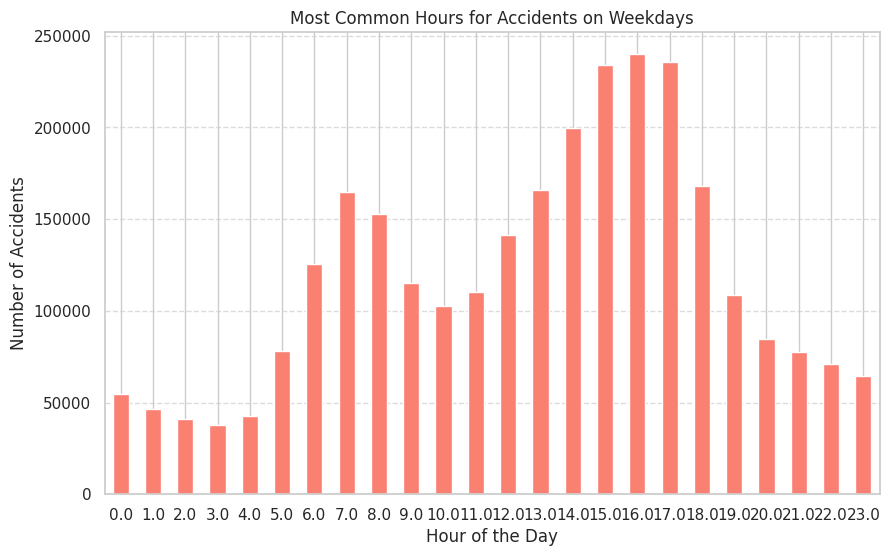

WeekDay Hours with the most accidents:
Hour
16    281031
15    276284
17    276092
14    243312
13    207448
18    206909
7     184643
12    180498
8     173664
6     144665
11    144641
19    143123
9     139896
10    132448
20    116880
21    108291
22     99718
5      96170
23     89720
0      81908
1      70768
2      66021
4      60426
3      57910
Name: count, dtype: int64


In [27]:
# Filter for weekdays (Is_Weekend is False)
weekday_data = my_df[my_df['Is_Weekend'] == False]

# Group by Hour and count accidents
accidents_by_hour_weekday = weekday_data.groupby('Hour').size()

# Plot the results
plt.figure(figsize=(10, 6))
accidents_by_hour_weekday.plot(kind='bar', color='salmon')
plt.title('Most Common Hours for Accidents on Weekdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

peak_hours = accidents_by_hour.sort_values(ascending=False).head(24)  # Top 5 hours with the most accidents
print("WeekDay Hours with the most accidents:")
print(peak_hours)

### <a id="p2"></a>

# 4. Group by date to aggregate


### <a id="p2"></a>

# 4.Model Training

In [28]:
feature_columns = [  col for col in my_df.columns if col.startswith('Temperature_Value') or col.startswith('HourRisk_Value') or col.startswith( 'Precipitation_Values')  or  col.startswith( 'Visibility_Value') or  col.startswith( 'Weather_Value')  or  col.startswith('Humidity_Value') ]

#or col.startswith( 'Precipitation_Values') or  col.startswith( 'Weather_Value')  or  col.startswith( 'Visibility_Value')  
  #                 or  col.startswith('Humidity_Value')   ]



additional_fields = [
    'Is_Weekend',
    'Traffic_Signal',
    'Is_Holiday',
    'Is_Night'
    
]

feature_columns.extend(additional_fields)

print(feature_columns)

['Temperature_Value_-20.0', 'Temperature_Value_-15.0', 'Temperature_Value_-5.0', 'Temperature_Value_5.0', 'Temperature_Value_15.0', 'Temperature_Value_25.0', 'Temperature_Value_35.0', 'Temperature_Value_45.0', 'Temperature_Value_50.0', 'Temperature_Value_nan', 'Humidity_Value_0-20%', 'Humidity_Value_21-40%', 'Humidity_Value_41-60%', 'Humidity_Value_61-80%', 'Humidity_Value_81-100%', 'Humidity_Value_nan', 'Visibility_Value_0-1 mi', 'Visibility_Value_1-3 mi', 'Visibility_Value_10-20 mi', 'Visibility_Value_20+ mi', 'Visibility_Value_3-5 mi', 'Visibility_Value_5-10 mi', 'Visibility_Value_nan', 'Precipitation_Values_Heavy', 'Precipitation_Values_Light', 'Precipitation_Values_Moderate', 'Precipitation_Values_None', 'Weather_Value_Cloudy', 'Weather_Value_Dust', 'Weather_Value_Fair', 'Weather_Value_Fog', 'Weather_Value_Other', 'Weather_Value_Rain', 'Weather_Value_Smoke', 'Weather_Value_Snow', 'Weather_Value_Squalls', 'Weather_Value_Thunder', 'Weather_Value_Wintry', 'HourRisk_Value_0', 'HourRis

In [35]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Ensure the 'Traffic_Signal' column is filled with 0 and converted to int
my_df['Traffic_Signal'] = my_df['Traffic_Signal'].fillna(0).astype(int)
my_feature_df = my_df[feature_columns].select_dtypes(include=['number']).fillna(0).astype(int)

#my_feature_df = my_df[feature_columns].fillna(0).astype(int)
my_feature_df['Date'] = my_df['Date']
filtered_df = my_feature_df[(my_feature_df['Is_Weekend'] == 0) & (my_feature_df['Is_Holiday'] == 0)]



df_daily = filtered_df.groupby('Date').size().reset_index(name='Accident_Count')
df_daily = pd.merge(df_daily,filtered_df, on='Date', how='left')
df_daily = df_daily.drop_duplicates(subset=['Date'])

#print(df_daily.head())

# Split into features (X) and target (y)
X = df_daily.drop(columns=['Date', 'Accident_Count'])  # Drop 'Date' and 'Accident_Count' columns
y = df_daily['Accident_Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('=== FINAL RESULT ===')
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train columns:", X_train.columns)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#model = LinearRegression()
#model.fit(X_train, y_train)

# Make predictions on the test set
#y_pred = model.predict(X_test)

#print('=== Model Evaluation ===')
#print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
#print("R^2 Score:", r2_score(y_test, y_pred))

#df_daily.head(5)




=== FINAL RESULT ===
Mean Squared Error: 1239646.4540229884
R^2 Score: 0.4252367927353017
X_train shape: (1390, 45)
y_train shape: (1390,)
X_train columns: Index(['Temperature_Value_-20.0', 'Temperature_Value_-15.0',
       'Temperature_Value_-5.0', 'Temperature_Value_5.0',
       'Temperature_Value_15.0', 'Temperature_Value_25.0',
       'Temperature_Value_35.0', 'Temperature_Value_45.0',
       'Temperature_Value_50.0', 'Temperature_Value_nan',
       'Humidity_Value_0-20%', 'Humidity_Value_21-40%',
       'Humidity_Value_41-60%', 'Humidity_Value_61-80%',
       'Humidity_Value_81-100%', 'Humidity_Value_nan',
       'Visibility_Value_0-1 mi', 'Visibility_Value_1-3 mi',
       'Visibility_Value_10-20 mi', 'Visibility_Value_20+ mi',
       'Visibility_Value_3-5 mi', 'Visibility_Value_5-10 mi',
       'Visibility_Value_nan', 'Precipitation_Values_Heavy',
       'Precipitation_Values_Light', 'Precipitation_Values_Moderate',
       'Precipitation_Values_None', 'Weather_Value_Cloudy',
    

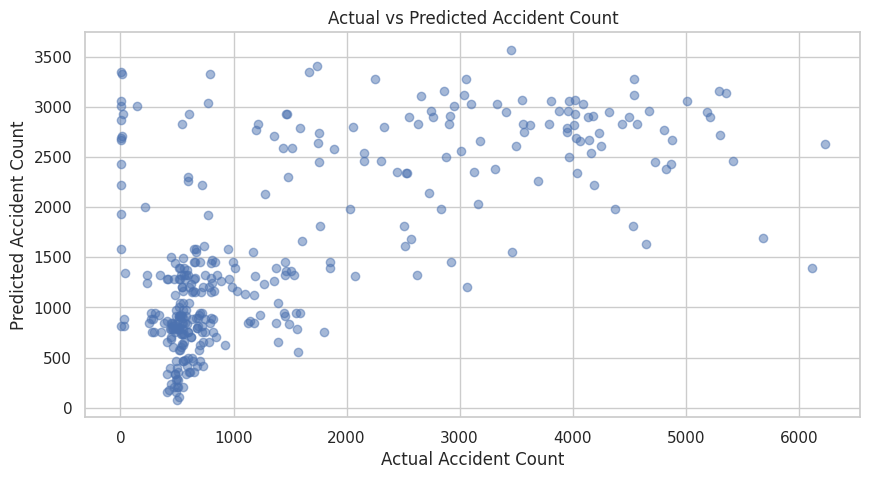

In [36]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Accident Count')
plt.ylabel('Predicted Accident Count')
plt.title('Actual vs Predicted Accident Count')
plt.grid(True)
plt.show()

In [38]:
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual Accident Count')
    plt.ylabel('Predicted Accident Count')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

Decision Tree MSE: 1251170.0604085678
Decision Tree R2: 0.41989386214090774


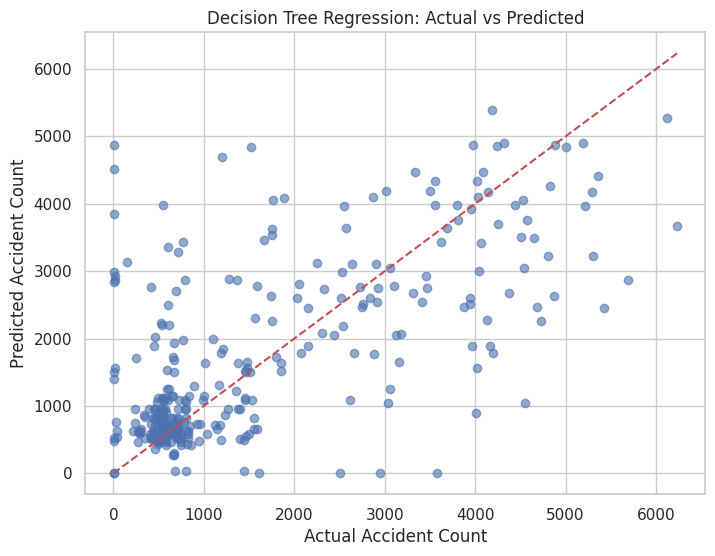

In [39]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)

# Evaluate
print('Decision Tree MSE:', mean_squared_error(y_test, y_pred_dt))
print('Decision Tree R2:', r2_score(y_test, y_pred_dt))
plot_predictions(y_test, y_pred_dt, 'Decision Tree Regression')

KNN Regression MSE: 1581883.7333333332
KNN Regression R2: 0.2665581665321647


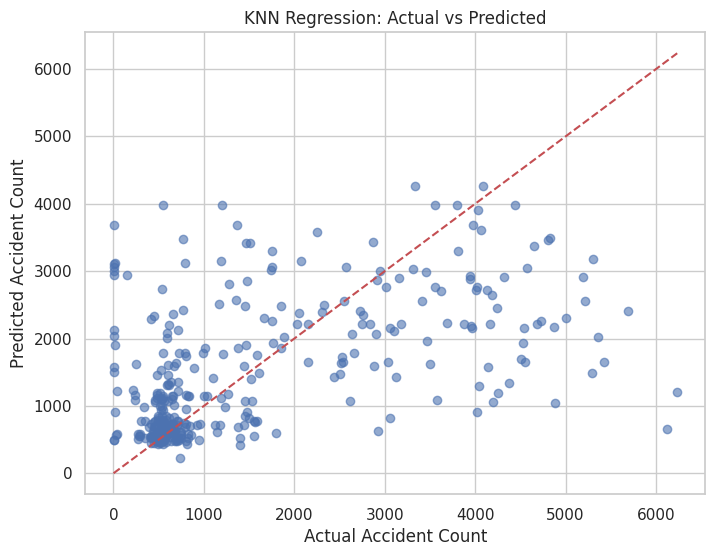

In [40]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluate
print('KNN Regression MSE:', mean_squared_error(y_test, y_pred_knn))
print('KNN Regression R2:', r2_score(y_test, y_pred_knn))
plot_predictions(y_test, y_pred_knn, 'KNN Regression')